# **Assignment 2**

## Framing the Problem


Industrial robotic arms often require extremely high precision to complete their tasks accurately and efficiently. Any deviation from expected performance can lead to defects, increased downtime, or even damage to equipment. Therefore, implementing real-time anomaly detection is crucial for ensuring smooth and reliable operation.  

The primary business objective of real-time anomaly detection is to identify irregularities during operation before they escalate into critical failures. By continuously monitoring sensor data, the system can detect deviations from normal patterns. This allows for immediate corrective action, such as halting the process or triggering automated adjustments.  

By preventing potential failures early, businesses can reduce waste, minimize downtime, and maintain high-quality production standards. Additionally, proactive anomaly detection enhances equipment longevity, reduces maintenance costs, and improves overall operational efficiency.



---
We will explore three different methods for anomaly detection: K-Means, DBSCAN and Gaussian Mixture.

Performance should be measured by validating the model on nomal data found in ``IMU_20Hz_freq_drop.csv`` and  `IMU_10Hz`. A suitable threshold will be chosen to detect unnormal behaviour over a time window.

* For K-Means we will compare the inertias of the clusters to the inertias generated from normal data.

* For DBSCAN we will use the fraction of datapoints that fall outside clusters.

* For Gaussian Mixture we will use BIC and AIC scores to select the number of components/clusters. The metrics indicates how well the model fits the data, while penalizing complxity. We will use the mean log-likelihood to determine anomlies. 



### Assumptions

* Due to how the IMU is set up for data collection, we assume some variations in data quality. The IMU is placed on a breadboard that is secured with a strap, meaning it is likely prone to small orienational variations between each recording. As we will see later, this could explain the minor deviations found in the normal data recorded from ``IMU_20Hz_freq_drop.csv``. To account for this, we will simply adjust the threshold (defining anomalies) accordingly.

* After testing with resampling techniques to maintain a consistent sampling frequency, without any significant differences, we assume that the sampling frequency of the different IMUs does not impose any difference.

# Collecting the Data

For anomaly detection to work, we need a sequential repetitive process. The model will then generate clusters based on normal data. 
Our chosen dataset is extracted form an industrial robot arm that sequentially performs three distinct tasks: screwdriving, painting, and pick-and-place.
The dataset is collected by Hakan Kayan and is found here:
https://www.kaggle.com/datasets/hkayan/industrial-robotic-arm-imu-data-casper-1-and-2?fbclid=IwY2xjawI3yJdleHRuA2FlbQIxMAABHeB7cl5kMDV8YOgyqVeK-oP1pkBnbs1WEpvr3ZeDjBVKGANccmx1C2IKeg_aem_ZMw13qbiYzDAL9aYGz2JHA

The dataset files contain IMU data at different sampling rates and configurations, including acceleration, gyroscope, and quaternion data. For this task, we will limit our scope to using only the accelerations, gyroscope and magnetometer without making complex estimations of the states.

The dataset includes data from five simulated anomalies: earthquake vibration, collision with the arm, platform impact, extra weight on the gripper, and unexpected magnetic fields. We will use these to test how well our models is capable of detecting anomalies.

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Imports and Functions

In [2]:
import seaborn as sns
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import ipywidgets as widgets
from IPython.display import display

def get_data_frame(filename):
    CSV_FOLDER_NAME = "Robotic Arm"
    csv_filepath = os.path.join(CSV_FOLDER_NAME, filename)
    return pd.read_csv(csv_filepath)

def plot_corr_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(12, 7))
    sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show() 

def add_time_column(df):
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df.set_index('time', inplace=True)
    return df

def extract_rolling_features(df):
    sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Use a rolling window of 1 second and extraxt key features
    features_df = df[sensor_cols].rolling(window='1S').agg(['mean', 'std'])

    # Flatten MultiIndex
    features_df.columns = ['_'.join(col).strip() for col in features_df.columns]
    
    # Remove nan (to be sure)
    features_df = features_df.dropna().reset_index(drop=True)
    
    return features_df

def resample_to_10Hz(df):
    # Behold kun numeriske kolonner for resampling
    df_numeric = df.select_dtypes(include=[np.number])

    # Resample til target frequency (10Hz = 100ms)
    df_resampled = df_numeric.resample("100ms").mean().dropna()
    return df_resampled


def plot_bic_aic(X_scaled, n_components_range, sample_size=10000):

    # Sample from X_scaled to increase performance
    if len(X_scaled) > sample_size:
        np.random.seed(21) 
        indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
        X_sampled = X_scaled[indices]
    else:
        X_sampled = X_scaled

    # Store metrics
    bic_values = []
    aic_values = []
    
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=21)
        gmm.fit(X_sampled)
        
        bic_values.append(gmm.bic(X_sampled))
        aic_values.append(gmm.aic(X_sampled))
        # print(f"n={n}: BIC={bic_values[-1]:.2f}, AIC={aic_values[-1]:.2f}")

    # Plotter BIC og AIC
    plt.figure(figsize=(8, 5))
    plt.plot(n_components_range, bic_values, label='BIC', marker='o')
    plt.plot(n_components_range, aic_values, label='AIC', marker='s')
    plt.xlabel('Number of components')
    plt.ylabel('Score')
    plt.title('BIC and AIC for GMM')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_anomalies_histogram(filename, threshold, gmm, scaler, x_start=-500, x_end=50, resample_10Hz=False):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10Hz to keep consistency
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(log_likelihood, bins=100, color='gray', alpha=0.7, label="Log-Likelihood", edgecolor='black', density=True)

    # KDE (Kernel Density Estimate) for the distribution
    kde = gaussian_kde(log_likelihood, bw_method='silverman')
    x_range = np.linspace(min(log_likelihood), max(log_likelihood), 1000)
    kde_values = kde(x_range)

    # Shaded region under the KDE curve
    plt.fill_between(x_range, kde_values, color='blue', alpha=0.2, label="Density")

    # Add a vertical line for anomaly threshold
    plt.axvline(threshold, color='coral', linestyle='dashed', linewidth=3, label="0.5 % Likelihood")

    # Add a vertical line for mean Log-Likelihood
    plt.axvline(log_likelihood.mean(), color='blue', linestyle='-', linewidth=2, label="Mean Log-Likelihood")

    # Add labels and title
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.title('Histogram of Log-Likelihood with Anomalies and KDE Distribution. ' + filename)
    plt.legend()

    plt.xlim(x_start, x_end)

    # Show plot
    plt.show()

def plot_log_likelihood_timeseries(filename, threshold, gmm, scaler, resample_10Hz=True):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10 Hz
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scalse the data
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies globally
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Get time values
    time_values = df.index  

    # Interactive widgets
    start_slider = widgets.IntSlider(value=0, min=0, max=len(time_values)-100, step=10, description='Start:')
    window_slider = widgets.IntSlider(value=500, min=100, max=5000, step=100, description='Window:')

    def update_plot(start, window):
        # Define plot end
        end = min(start + window, len(time_values))

        # Anomaly fraction of current time window
        log_likelihood_mean = log_likelihood[start:end].mean()

        # Update new plot
        plt.figure(figsize=(12, 6))
        plt.plot(time_values[start:end], log_likelihood[start:end], label="Log-Likelihood", color="gray")
        # plt.scatter(time_values[start:end][anomalies[start:end]], 
        #             log_likelihood[start:end][anomalies[start:end]], 
        #             color='black', label="Anomalies", zorder=3, s=3)
        
        plt.axhline(threshold, color='coral', linestyle='dashed', linewidth=3, label="0.5 % Likelihood")

        plt.axhline(log_likelihood_mean, color='blue', linestyle='-', linewidth=2, label="Mean Log-Likelihood (current window)")


        # Display current anomaly fraction
        text_str = f"Mean Log-Likelihood (current window): {log_likelihood_mean:.2f}"
        plt.text(0.02, 0.05, text_str, transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        plt.xlabel("Time")
        plt.ylabel("Log-Likelihood")
        plt.title("Log-Likelihood Timeseries " + filename)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    # Make interactive plot
    interactive_plot = widgets.interactive(update_plot, start=start_slider, window=window_slider)
    display(interactive_plot)

# Explore the Data

We start by exploriing the data from normal operation (``IMU_10Hz.csv``) 

In [3]:
raw_data = get_data_frame("IMU_10Hz.csv")
raw_data.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874937 entries, 0 to 874936
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874937 non-null  object 
 1   time    874937 non-null  int64  
 2   accX    874937 non-null  float64
 3   accY    874937 non-null  float64
 4   accZ    874937 non-null  float64
 5   gyroX   874937 non-null  float64
 6   gyroY   874937 non-null  float64
 7   gyroZ   874937 non-null  float64
 8   magX    874937 non-null  float64
 9   magY    874937 non-null  float64
 10  magZ    874937 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB


Looking at the object `name`, we see that it contains "IMUX", where X is a number, likely corresponding to the timeseries. We assume that the IMUs are identical and we can ignore this column.

In [7]:
# Look for missing data
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


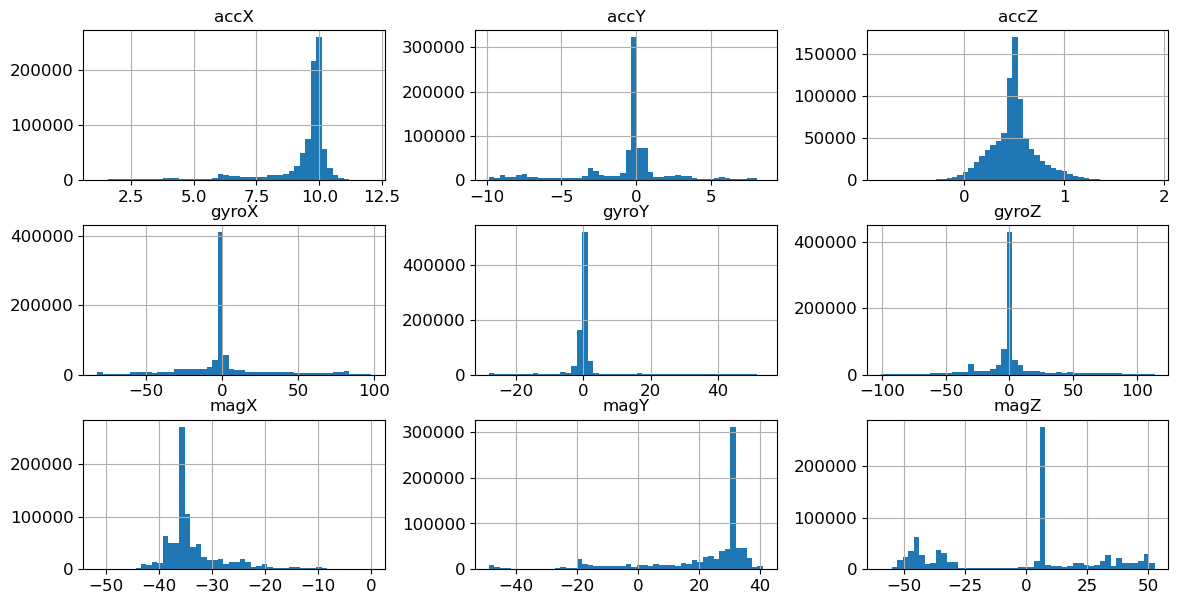

In [4]:
# Plot histogram of features
raw_data.drop(columns=['time']).hist(bins=50, figsize=(14,7))
plt.show()

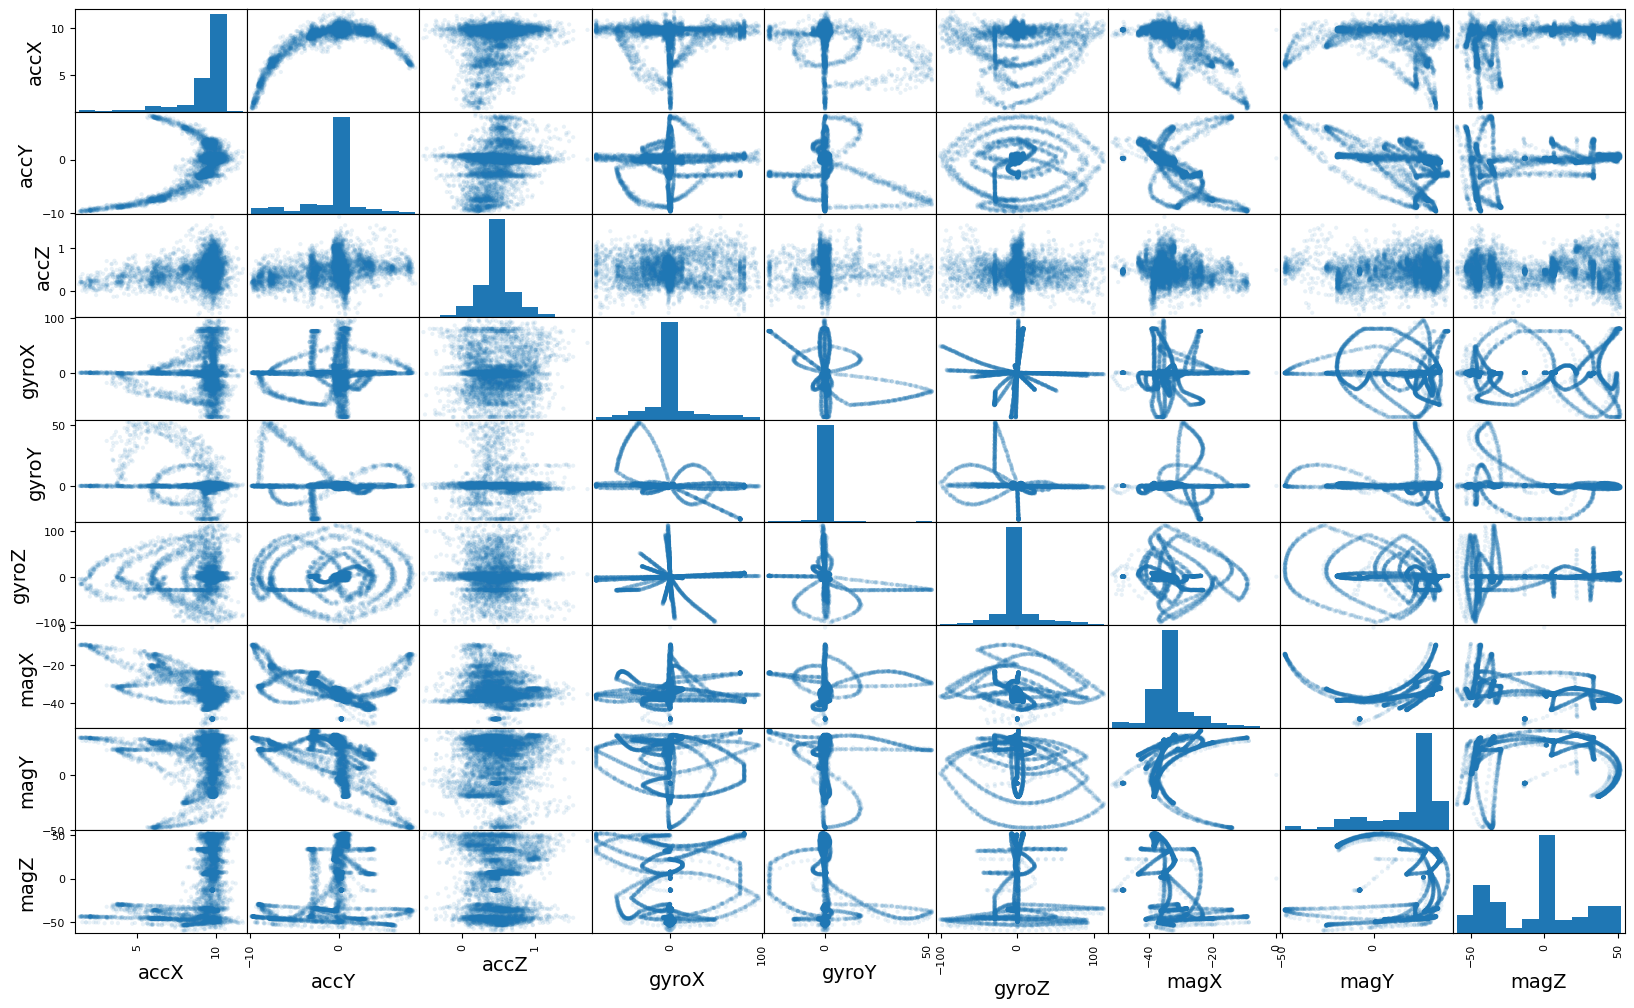

In [9]:
from pandas.plotting import scatter_matrix
scatter_matrix(raw_data[:10000].drop(columns=['time']), figsize=(20, 12), alpha=0.1)

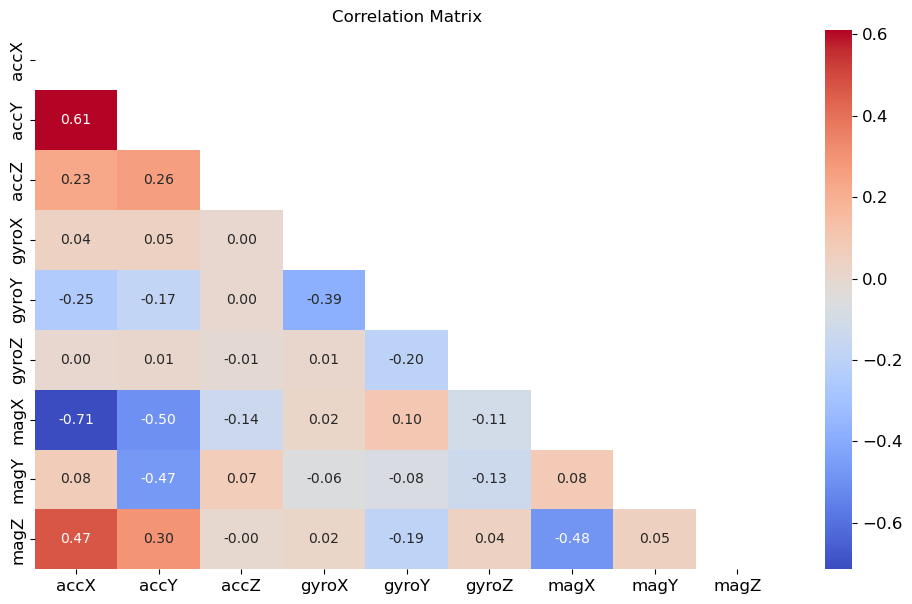

In [11]:
plot_corr_matrix(raw_data.drop(columns=['name', 'time']))

# TODO: Legg til figurer som viser scatter plot av de forskjellige features

# Prepare the Data

### Adding DateTime (Pandas functionality)
To add functionality to the timeseries we add a "DateTime" collumn. This allows ut to use processing functions such as ``.rolling()`` (as we will see later). 

In [28]:
raw_data = add_time_column(raw_data)
raw_data.head()

,name,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
time,,,,,,,,,,
2023-06-06 14:47:08.391,IMU8,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
2023-06-06 14:47:08.537,IMU8,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2023-06-06 14:47:08.585,IMU8,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
2023-06-06 14:47:08.682,IMU8,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
2023-06-06 14:47:08.780,IMU8,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


### Reduce the large training set
To make training faster, we will split the timeseries containing close to a million datapoints in half.

In [29]:
# Split normal data into test and train using a ratio to improve speed
ratio_train = 0.5

split_idx = int(len(raw_data) * ratio_train)

# Split the data
train_data = raw_data[:split_idx]

print(f'Length train: {len(train_data)}')

Length train: 437468


Now, lets do some preprocessing of the data. Due to the varying sampling frequencies across the timeseries (as explained by the creator of the dataset), we initially chose to resample all new data to match the training frequency of 10 Hz. We later found that this made no significant difference to the results. ``resample_to_10Hz()`` is left as an option, but not necessary. The function ``extract_rolling_features()`` extracts the mean and the standard deviation from a rolling timewindow of 1 second. The reasoning for doing this is to smooth out sensor noise.

In [12]:
train_data_copy = train_data.copy()

# Resample to 10Hz
# train_data_copy = resample_to_10Hz(train_data_copy)

# Extract rolling features
X_normal = extract_rolling_features(train_data_copy)

X_normal.head()

,accX_mean,accX_std,accY_mean,accY_std,accZ_mean,accZ_std,gyroX_mean,gyroX_std,gyroY_mean,gyroY_std,gyroZ_mean,gyroZ_std,magX_mean,magX_std,magY_mean,magY_std,magZ_mean,magZ_std
0,9.789891,0.023701,0.247800,0.022008,0.489614,0.001693,-0.031250,0.132583,0.000000,0.000000,0.0,0.0,-24.139999,34.139115,-3.720000,5.260874,-6.615385,9.355567
1,9.791487,0.016986,0.248997,0.015700,0.474052,0.026981,-0.083333,0.130104,0.000000,0.000000,0.0,0.0,-32.280000,27.955651,-4.973333,4.307079,-8.820513,7.638788
2,9.786299,0.017320,0.242413,0.018377,0.466869,0.026300,-0.078125,0.106739,0.015625,0.031250,0.0,0.0,-36.340000,24.226982,-5.560000,3.707290,-9.980769,6.654735
3,9.787496,0.015237,0.238462,0.018202,0.466390,0.022802,-0.062500,0.098821,0.012500,0.027951,0.0,0.0,-38.744000,21.658857,-5.904000,3.301466,-10.723077,5.997435
4,9.787496,0.013628,0.239420,0.016449,0.472057,0.024669,-0.072917,0.091998,0.000000,0.039528,0.0,0.0,-40.320000,19.753165,-6.180000,3.029323,-11.269231,5.528570


# Scaling the Data
The data is scaled using `StandardScaler()`.

In [13]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# **K-Means**

K-Means is a clustering algorithm that groups data into K clusters by minimizing the distance between points and their cluster centroids.

Inertia measures how tightly data points are clustered by summing the squared distances from each point to its nearest centroid. Lower inertia indicates better clustering, but too many clusters can lead to overfitting.

In [30]:
# TODO: Legg til endre sin kode

# **Gaussian Mixture**

A Gaussian Mixture Model (GMM) is a probabilistic model that represents data as a combination of multiple Gaussian distributions. This makes it an ideal choice for anomaly detection.

Each data point is assigned a probability of belonging to different clusters, making GMM more flexible than k-means for capturing complex data distributions.

### Finding the Number of Clusters for Gaussian Mixture
We analyse the BIC and AIC scores to determine the number of components (clusters) for GMM. AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are measures of model quality that balance goodness of fit and model complexity.

* AIC favors models that fit the data well but penalizes complexity less strictly.
* BIC applies a stronger penalty for complexity, often leading to simpler models.

Lower AIC/BIC values indicate a better model, but too many clusters in GMM (Gaussian Mixture Model) can lead to overfitting.

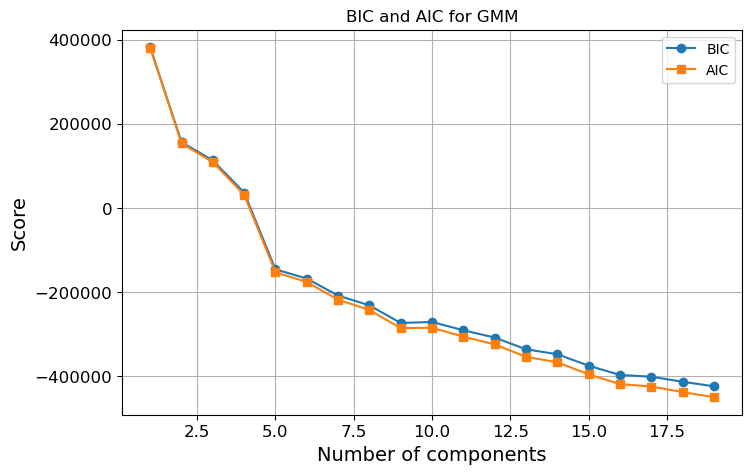

In [14]:
# Check for a range of n_components
n_components_range = range(1, 20)

plot_bic_aic(X_normal_scaled, n_components_range)

As mentioned, too many clusters may cause the model to overfit on noise, as well as making the model compytationally expensive. For anomaly detection in our case, chosing ``n_components`` around the elbow point is sufficient. We identify the elbow point at 5, but we found that ``n_components = 6`` works better in our case.

# Training Gaussian Mixture

In [15]:
from sklearn.mixture import GaussianMixture

# Tune number of components
n_components = 6

# Train the model on normal data
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=21)
gmm.fit(X_normal_scaled)

GaussianMixture(n_components=6, random_state=21)

### Define a Threshold
We define a threshold to indicate how unlikely new data results are. Based on the training data, we chose a small percentile of 0.5%. This means that if the mean likelihood falls below this threshold, we can theoretically be 99.5% confident that the robot arm is not operating as expected. This is most definatley not true in our case, since the IMU is unlikely to be mounted concistantly (see assumptions). We instead use the threshold as an indication.

In [16]:
# Calculate threshold based on training data
log_likelihood_train = gmm.score_samples(X_normal_scaled)
threshold = np.percentile(log_likelihood_train, 0.5)

# Testing
Lets first validate our model on the whole timeseries that the model is partially trained on.

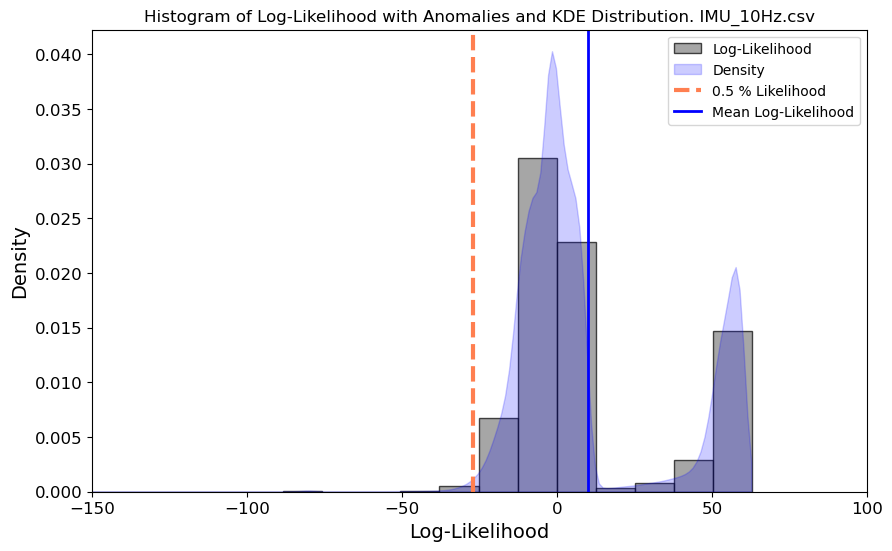

In [17]:
plot_anomalies_histogram("IMU_10Hz.csv", threshold, gmm, scaler, x_start=-150, x_end=100)

As expected, we get a mean log-likelihood of approxemately 10.

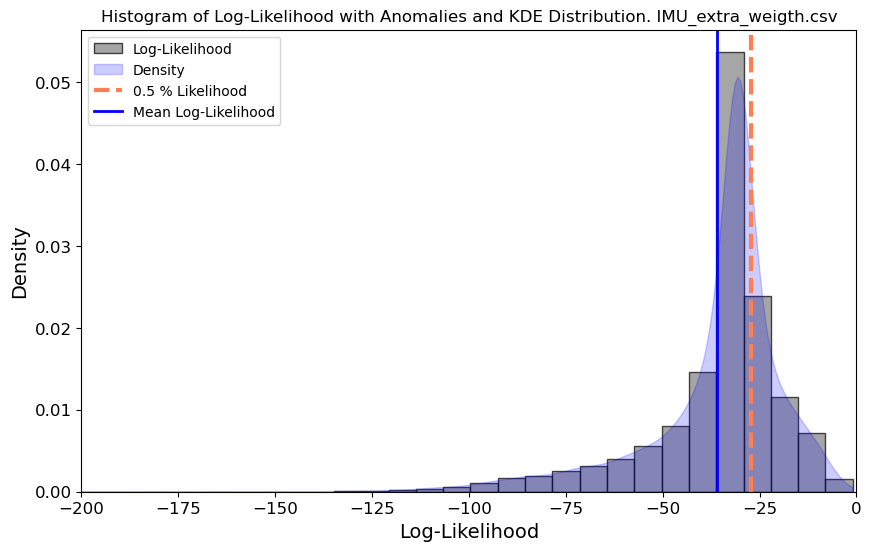

In [18]:
plot_anomalies_histogram("IMU_extra_weigth.csv", threshold, gmm, scaler, x_start=-200, x_end=0)

For ``IMU_extra_weigth.csv`` we see that the mean of the log-likelihood lies well below the 0.5% likelihood threshold. We can therfore confidently conclude from the timeseries that the robot arm contains faults and need attention. The same can be said about the timeseries below, which is simulating an earthquake.

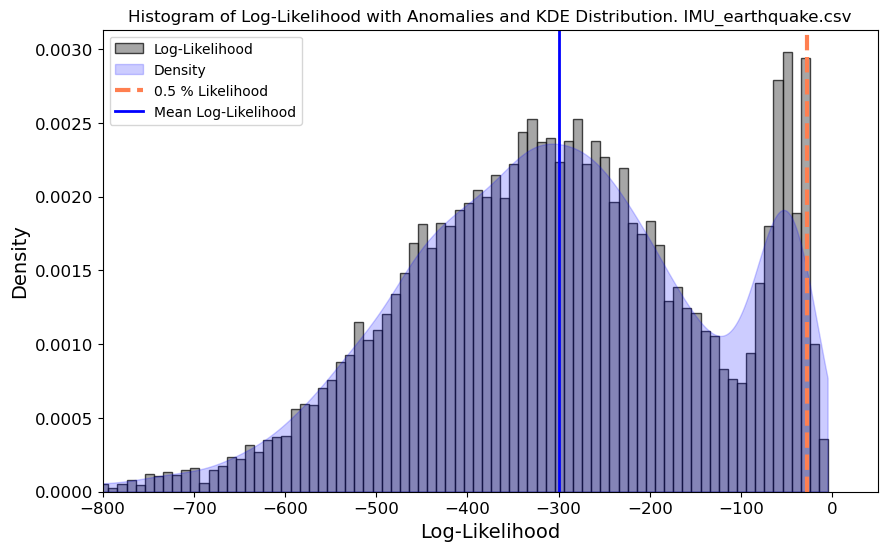

In [19]:
plot_anomalies_histogram("IMU_earthquake.csv", threshold, gmm, scaler, x_start=-800)

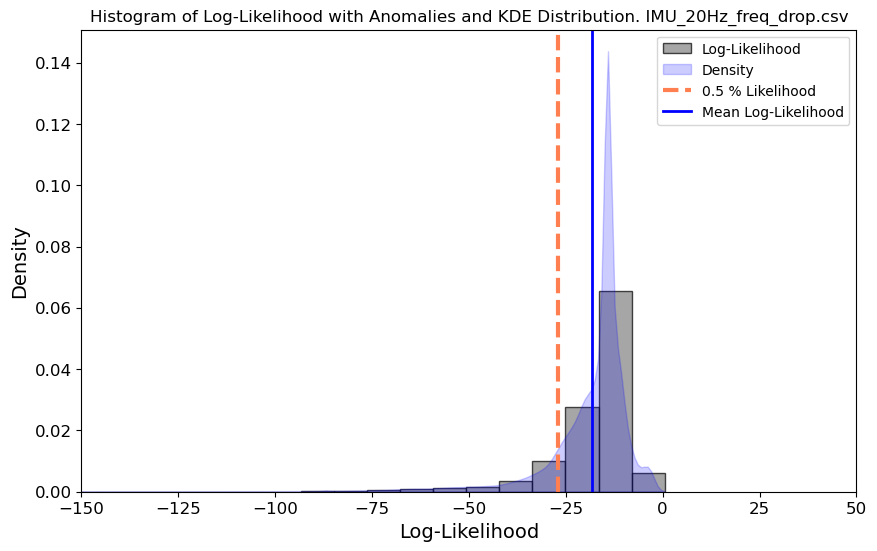

In [20]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold, gmm, scaler, x_start=-150, x_end=50)

We know that ``IMU_20Hz_freq_drop.csv`` should only contain normal data, but it still has its mean log-likelihood well below zero. This is likely due to the setup of the IMU (see assumptions).

We still see that the mean log-likelihood is well above the threshold, which is good.

## Simulation of real-time data using GMM

To detect unusual behavior, we cannot rely on a single data point; instead, we must analyze data over a time window. This approach helps account for random spikes, which are common and often caused by sensor noise rather than actual anomalies.

The function below calculates the mean log-likelihood within the current time window, providing a more robust indicator of anomalies. Additionally, the window is interactive, allowing for dynamic adjustments to better observe trends and detect deviations. By adjusting the "Start" slider, the system simulates how real-time data could be collected and used to trigger an alarm if an anomaly is detected (blue line below orange means something is wrong).

In [21]:
plot_log_likelihood_timeseries("IMU_extra_weigth.csv", threshold, gmm, scaler)

interactive(children=(IntSlider(value=0, description='Start:', max=10093, step=10), IntSlider(value=500, descr…